In [3]:
import numpy as np
np.random.seed(42)

import random
random.seed(42)

In [18]:
#Load data in and create ratings matrix
#Do we remove zero columns?

import pandas
import numpy as np

ratings_df = pandas.read_csv('ratings.csv')

userIDs = ratings_df['userId'].values
movies = ratings_df['movieId'].values
ratings = ratings_df['rating'].values

#Make ratings matrix
max_movie = max(movies)
max_userID = max(userIDs)

ratings_mat = np.zeros((max_userID, max_movie))

for i in range(len(userIDs)):
    sel_userID = userIDs[i]
    sel_movie = movies[i]
    sel_rating = ratings[i]
    #Make user 1 be index 0, etc.
    ratings_mat[sel_userID - 1, sel_movie - 1] = sel_rating
    
#Remove zero columns
idx = np.argwhere(np.all(ratings_mat[..., :] == 0, axis=0))
ratings_mat = np.delete(ratings_mat, idx, axis=1)

#Remove zero rows (should be none, but just in case)
idx = np.argwhere(np.all(ratings_mat[..., :] == 0, axis=1))
ratings_mat = np.delete(ratings_mat, idx, axis=0)

sparsity = np.count_nonzero(ratings_mat)/(np.prod(ratings_mat.shape))

print("Sparsity is: {}".format(sparsity))

[[    32]
 [    34]
 [    36]
 ...
 [193605]
 [193606]
 [193607]]
Sparsity is: 0.016999683055613623


In [5]:
#Q2

import matplotlib.pyplot as plt

#Bars are centered around the ratings (0.5, 1, 1.5, etc.)
plt.hist(ratings, bins=[-0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25])
plt.xlabel("Rating")
plt.title("Histogram of Movie Ratings")
plt.ylabel("Number of Occurences")
plt.show()

#Looks normally distributed, mean around 3.5-4. Most reviewed movies were enjoyed by the viewer
#Nobody gave a review of 0/5

<Figure size 640x480 with 1 Axes>

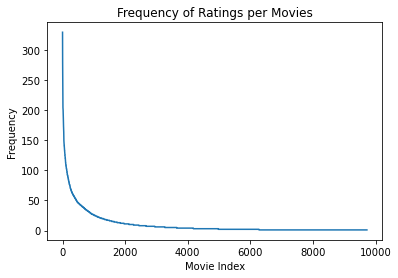

In [6]:
#Q3

freqs = np.count_nonzero(ratings_mat, axis=0)

freqs = np.sort(freqs)
movie_ind = np.flip(np.arange(freqs.shape[0]))
plt.plot(movie_ind,freqs)
plt.xlabel("Movie Index")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings per Movies")
plt.show()

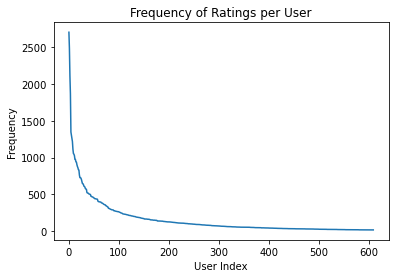

In [7]:
#Q4

freqs = np.count_nonzero(ratings_mat, axis=1)

freqs = np.sort(freqs)
movie_ind = np.flip(np.arange(freqs.shape[0]))
plt.plot(movie_ind,freqs)
plt.xlabel("User Index")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings per User")
plt.show()

Q5

Recommendations will be heavily weighted towards a few hundred movies, since those are the most reviewed ones. Most movies have less than 25 reviews, so our matrix will be sparse.

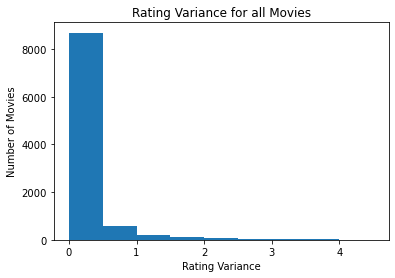

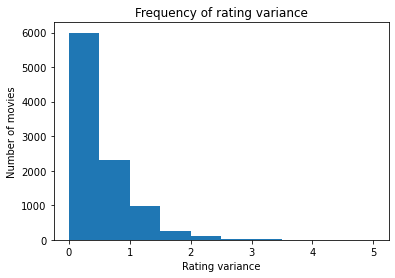

In [21]:
#Q6
#Variances are strangely low

#Variances are low for most movies (0-0.5). This suggests that most users seem to agree on which movies are good/bad
variances = np.var(ratings_mat, axis=0)

hist_bins = np.arange(0, 5, 0.5)
plt.hist(variances, bins=hist_bins)
plt.xlabel("Rating Variance")
plt.title("Rating Variance for all Movies")
plt.ylabel("Number of Movies")
plt.show()

Q7

$\mu_u = \frac{\sum_{k \in{I_u}}r_{uk}}{length(I_u)}$

Q8

$I_u \cap I_v$ represents the set of indices for the movies rated by both users u and v. This can be equal to $\emptyset$, meaning that they haven't seen any of the same movies. Given that our rating matrix is very sparse, this is likely to be the case if we were to randomly select any two users.

Q9

This mean-centering process helps reduce the influence of outliers, and reduce bias in our predictions. This would remove the effect of users that only give high/low ratings of movies, since the low variance of their rankings suggests that their opinions on movies are biased and may not be suitable for movie recommendations. 

In [51]:
#Q10

from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.similarities import pearson
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)

sim_options = {'name': 'pearson',
               'user_based': True
               }

#Do we need to add skip_lines=1 to remove the headers?
reader_df_pd = Reader()
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

print(ratings_df_sup)
rmse_vals = []
mae_vals = []
k_vals = np.arange(2, 102, 2)

#Unnecessarilly large number of k values - could stop at 50 and get the same result
for k in k_vals:
    if (k % 10 == 0):
        print("Working with k = {}".format(k))
    curr_knn = KNNWithMeans(k, sim_options=sim_options, verbose=False)
    cv_result = cross_validate(curr_knn, ratings_df_sup, cv=10, measures=['rmse', 'mae'])
    rmse_vals.append(np.average(cv_result['test_rmse']))
    mae_vals.append(np.average(cv_result['test_mae']))

plt.plot(k_vals, rmse_vals)
plt.title("KNNWithMeans Average RMSE Errors for Various k")
plt.xlabel("k")
plt.xlabel("Average RMSE")
plt.show()

plt.figure;
plt.plot(k_vals, mae_vals)
plt.title("KNNWithMeans Average MAE Errors for Various k")
plt.xlabel("k")
plt.xlabel("Average MAE")
plt.show()

KeyboardInterrupt: 

In [ ]:
#Q11

#We can see that our minimum k for both is around 24. The steady state averages for both are as follows:

rmse_min_k = 24
mae_min_k = 24
print("Steady state average RMSE error = {}".format(np.average(rmse_vals[rmse_min_k//2 - 1:])))
print("Steady state average MAE error = {}".format(np.average(mae_vals[mae_min_k//2 - 1:])))
      

Working with k = 10
Working with k = 20
Working with k = 30
Working with k = 40
Working with k = 50
Working with k = 60
Working with k = 70
Working with k = 80
Working with k = 90
Working with k = 100


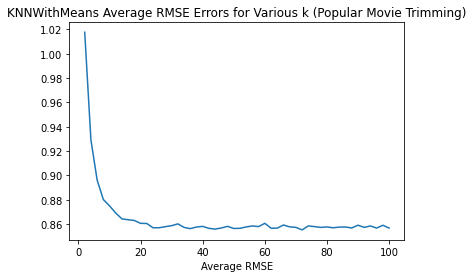

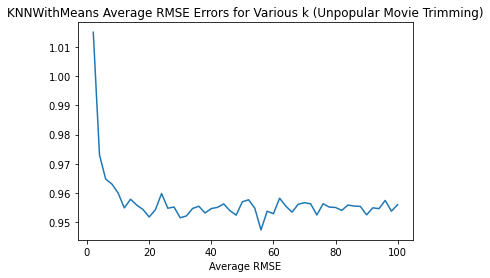

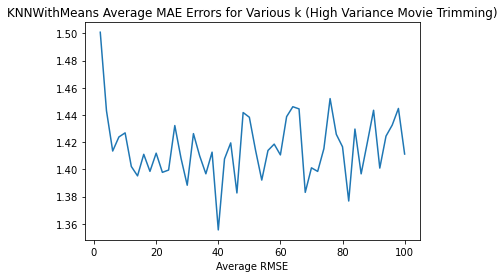

In [65]:
#Q12-14

from surprise import accuracy
from surprise.model_selection import KFold


def trim_pop(arr):
    
    elem_dict = {}
    ret_arr = []
    for elem in arr:
        
        #Use movieID as key
        if (elem[1] not in elem_dict.keys()):
            elem_dict[elem[1]] = [elem]
        else:
            elem_dict[elem[1]].append(elem)
    
    for movID in elem_dict.keys():
        if (len(elem_dict[movID]) > 2):
            for elem in elem_dict[movID]:
                ret_arr.append(elem)
    return ret_arr

def trim_unpop(arr):
    elem_dict = {}
    ret_arr = []
    for elem in arr:
        
        #Use movieID as key
        if (elem[1] not in elem_dict.keys()):
            elem_dict[elem[1]] = [elem]
        else:
            elem_dict[elem[1]].append(elem)
    
    for movID in elem_dict.keys():
        if (len(elem_dict[movID]) <= 2):
            for elem in elem_dict[movID]:
                ret_arr.append(elem)
    return ret_arr

def trim_var(arr):
    elem_dict = {}
    ret_arr = []
    for elem in arr:
        
        #Use movieID as key
        if (elem[1] not in elem_dict.keys()):
            elem_dict[elem[1]] = [elem]
        else:
            elem_dict[elem[1]].append(elem)
    
    for movID in elem_dict.keys():
        if (len(elem_dict[movID]) >= 5):
            rating_arr = []
            elem_arr = []
            for elem in elem_dict[movID]:
                rating_arr.append(elem[2])
                elem_arr.append(elem)
            if (np.var(np.asarray(rating_arr)) >= 2):
                ret_arr += elem_arr
                
    return ret_arr


num_splits = 10
kf = KFold(n_splits=num_splits)

k_vals = np.arange(2, 102, 2)
rmse_vals_12 = []
rmse_vals_13 = []
rmse_vals_14 = []

for k in k_vals:
    
    if (k % 10 == 0):
        print("Working with k = {}".format(k))
        
    algo = KNNWithMeans(k, sim_options=sim_options, verbose=False)
    temp_rmse_12 = 0
    temp_rmse_13 = 0
    temp_rmse_14 = 0
    
    for trainset, testset in kf.split(ratings_df_sup):

        #fit training set
        algo.fit(trainset)
        
        
        #Q12
        predictions = algo.test(trim_pop(testset))
        temp_rmse_12 += accuracy.rmse(predictions, verbose=False)

        #Q13
        predictions = algo.test(trim_unpop(testset))
        temp_rmse_13 += accuracy.rmse(predictions, verbose=False)
        
        #Q14
        predictions = algo.test(trim_var(testset))
        temp_rmse_14 += accuracy.rmse(predictions, verbose=False)
    
    rmse_vals_12.append(temp_rmse_12/num_splits)
    rmse_vals_13.append(temp_rmse_13/num_splits)
    rmse_vals_14.append(temp_rmse_14/num_splits)


plt.plot(k_vals, rmse_vals_12)
plt.title("KNNWithMeans Average RMSE Errors for Various k (Popular Movie Trimming)")
plt.xlabel("k")
plt.xlabel("Average RMSE")
plt.show()

plt.plot(k_vals, rmse_vals_13)
plt.title("KNNWithMeans Average RMSE Errors for Various k (Unpopular Movie Trimming)")
plt.xlabel("k")
plt.xlabel("Average RMSE")
plt.show()

plt.figure;
plt.plot(k_vals, rmse_vals_14)
plt.title("KNNWithMeans Average MAE Errors for Various k (High Variance Movie Trimming)")
plt.xlabel("k")
plt.xlabel("Average RMSE")
plt.show()

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
